In [16]:
import tensorflow as tf
# import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import pandas as pd
from input_fn import load_labels

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Choosing Best Parameters.

In [101]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import pandas as pd
from input_fn import load_labels

def choose_threshold(val_pred_dense, val_true_dense, universal_threshold=False):
    '''
    val_pred_dense, val_true_dense: validation_size*num_classes
    universal_threshold: whether to choose a threshold based on MicroF1
    '''
    # Micro: choose a universal threshold for all classes
    if universal_threshold:
        p, r, th = precision_recall_curve(val_true_dense.flatten(), val_pred_dense.flatten())
        f1=2.0*p*r/(p+r+1e-10)
        best_idx=np.argmax(f1)
        return th[best_idx]
    
            
    # Micro: for each of the class
    pred_threshold=[]
    for i in range(228):
        p, r, th = precision_recall_curve(val_true_dense[i], val_pred_dense[i])
        f1=2.0*p*r/(p+r+1e-10)
        best_idx=np.argmax(f1)
        pred_threshold.append(th[best_idx])
        
#     # Macro: for each of the class
#     pred_threshold=[]
#     for i in range(228):
#         p, r, th = precision_recall_curve(val_true_dense[i], val_pred_dense[i])
#         f1=2.0*p*r/(p+r+1e-10)
#         best_idx=np.argmax(f1)
#         pred_threshold.append(th[best_idx])
    return pred_threshold

def eval_with_threshold(val_pred, val_true, thresholds):
    '''
    evaluate the micro F1 score with the given threshold
    '''
    val_pred = (val_pred >= thresholds).astype(int)
    f1 = f1_score(val_true, val_pred, average='micro')
    return f1
            
def read_validation_predictions(val_pred_file, val_label_file):
    label_id = load_labels(val_label_file)
    
    val_pred = pd.read_csv(val_pred_file)['label_prob'].map(lambda x: np.array([float(v) for v in x.split(' ')])).values
    val_pred = np.array(val_pred.tolist())
    val_true = np.zeros_like(val_pred)
    for i in range(len(label_id)):
        key=str(i+1)
        val_true[i][np.array(label_id[key])-1]=1
    
    return val_pred, val_true

def save_thresholds_to_file(thresholds, file_name):
    df = pd.DataFrame({'thresholds': thresholds})
    df.to_csv(file_name)

In [87]:
# Run threshold choosing function

val_pred_file='/home/shared/cs231n-fashion/model_dir/baseline_dense/valid_debug_dump.csv'
val_label_file='/home/fashion/data/validation.json'

val_pred, val_true = read_validation_predictions(val_pred_file, val_label_file)

per_class_threshold=choose_threshold(val_pred, val_true)
print(per_class_threshold)

universal_threshold=choose_threshold(val_pred, val_true, True)
print(universal_threshold)

print(eval_with_threshold(val_pred, val_true, per_class_threshold))
print(eval_with_threshold(val_pred, val_true, universal_threshold))

[0.54, 0.11, 0.19, 0.43, 0.22, 0.28, 0.23, 0.25, 0.07, 0.3, 0.06, 0.24, 0.1, 0.88, 0.48, 0.14, 0.41, 0.16, 0.37, 0.2, 0.32, 0.38, 0.14, 0.29, 0.2, 0.15, 0.09, 0.11, 0.29, 0.15, 0.24, 0.27, 0.16, 0.07, 0.13, 0.06, 0.12, 0.27, 0.06, 0.27, 0.27, 0.2, 0.25, 0.4, 0.77, 0.31, 0.11, 0.25, 0.62, 0.21, 0.78, 0.04, 0.26, 0.4, 0.16, 0.07, 0.09, 0.17, 0.3, 0.42, 0.48, 0.18, 0.05, 0.53, 0.23, 0.09, 0.19, 0.15, 0.52, 0.49, 0.06, 0.37, 0.5, 0.16, 0.36, 0.27, 0.14, 0.54, 0.42, 0.21, 0.17, 0.28, 0.21, 0.54, 0.18, 0.69, 0.37, 0.13, 0.14, 0.16, 0.25, 0.46, 0.12, 0.27, 0.36, 0.17, 0.22, 0.67, 0.25, 0.4, 0.23, 0.2, 0.33, 0.15, 0.21, 0.45, 0.13, 0.1, 0.13, 0.22, 0.24, 0.67, 0.26, 0.14, 0.26, 0.15, 0.22, 0.29, 0.19, 0.11, 0.72, 0.2, 0.28, 0.27, 0.4, 0.14, 0.45, 0.41, 0.1, 0.27, 0.2, 0.12, 0.26, 0.31, 0.22, 0.11, 0.4, 0.32, 0.23, 0.31, 0.33, 0.18, 0.29, 0.45, 0.21, 0.46, 0.23, 0.95, 0.52, 0.1, 0.21, 0.3, 0.61, 0.18, 0.21, 0.14, 0.44, 0.18, 0.13, 0.15, 0.91, 0.21, 0.23, 0.11, 0.07, 0.16, 0.3, 0.71, 0.21, 0.12,

In [103]:
thresholds_filename='/home/shared/cs231n-fashion/model_dir/baseline_dense/thresholds.csv'
save_thresholds_to_file(per_class_threshold, thresholds_filename)

In [104]:
df=pd.read_csv(thresholds_filename)
df['thresholds'].values

array([0.54, 0.11, 0.19, 0.43, 0.22, 0.28, 0.23, 0.25, 0.07, 0.3 , 0.06,
       0.24, 0.1 , 0.88, 0.48, 0.14, 0.41, 0.16, 0.37, 0.2 , 0.32, 0.38,
       0.14, 0.29, 0.2 , 0.15, 0.09, 0.11, 0.29, 0.15, 0.24, 0.27, 0.16,
       0.07, 0.13, 0.06, 0.12, 0.27, 0.06, 0.27, 0.27, 0.2 , 0.25, 0.4 ,
       0.77, 0.31, 0.11, 0.25, 0.62, 0.21, 0.78, 0.04, 0.26, 0.4 , 0.16,
       0.07, 0.09, 0.17, 0.3 , 0.42, 0.48, 0.18, 0.05, 0.53, 0.23, 0.09,
       0.19, 0.15, 0.52, 0.49, 0.06, 0.37, 0.5 , 0.16, 0.36, 0.27, 0.14,
       0.54, 0.42, 0.21, 0.17, 0.28, 0.21, 0.54, 0.18, 0.69, 0.37, 0.13,
       0.14, 0.16, 0.25, 0.46, 0.12, 0.27, 0.36, 0.17, 0.22, 0.67, 0.25,
       0.4 , 0.23, 0.2 , 0.33, 0.15, 0.21, 0.45, 0.13, 0.1 , 0.13, 0.22,
       0.24, 0.67, 0.26, 0.14, 0.26, 0.15, 0.22, 0.29, 0.19, 0.11, 0.72,
       0.2 , 0.28, 0.27, 0.4 , 0.14, 0.45, 0.41, 0.1 , 0.27, 0.2 , 0.12,
       0.26, 0.31, 0.22, 0.11, 0.4 , 0.32, 0.23, 0.31, 0.33, 0.18, 0.29,
       0.45, 0.21, 0.46, 0.23, 0.95, 0.52, 0.1 , 0.

# Play with input_fn

In [11]:
import numpy as np

np.linspace(0.05, 0.95, num=19)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [3]:
# Define global variables.
hidden_size = 100
num_classes = 228
learning_rate = 3e-4
num_train_steps = 10
num_train_per_eval = 2

# input_fn arguments.
should_augment = False
images_limit = 1000  # How many images to train.
batch_size = 32
num_threads = 8
input_folder = '/home/shared/cs231n-fashion/data/train_processed'
label_json_path = '/home/shared/cs231n-fashion/data/train.json'

In [4]:
# Set up some global variables
gpu_to_use = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_to_use)

In [8]:
from PIL import Image
import numpy as np
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _label_feature(labels):
    return _bytes_feature(''.join([str(i) for i in labels]))

tfrecords_filename = '/home/shared/cs231n-fashion/data/train_empty.tfrecords'

filename_pairs = [
('/home/shared/cs231n-fashion/data/train_processed/36.jpg', [1 for i in range(228)])
]
 
writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, labels in filename_pairs:
    
    img = np.array(Image.open(img_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, labels))
    
    img_raw = img.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'label_raw': _int64_list_feature(labels)}))
    
    writer.write(example.SerializeToString())

writer.close()



In [9]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    labels = (example.features.feature['label_raw']
                                .int64_list.value)

    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    reconstructed_images.append((reconstructed_img, labels))

True
True


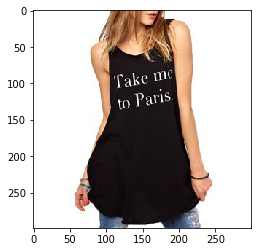

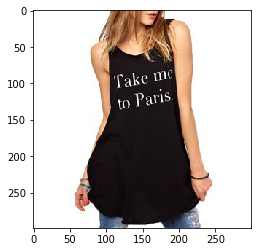

In [12]:
for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))
    plt.imshow(original_pair[0])
    plt.show()
    plt.imshow(reconstructed_pair[0])

In [ ]:
data_path = '/home/shared/cs231n-fashion/data/validation_processed.tfrecords/'  # address to save the hdf5 file
with tf.Session() as sess:
    feature = {
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_float': tf.FixedLenFeature([], tf.float32),
        'labels': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    
    # Cast label data into int32
    label = tf.cast(features['labels'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    image *= 255
    
    


/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


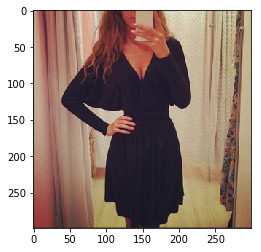

[62, 17, 66, 214, 105, 137, 85]


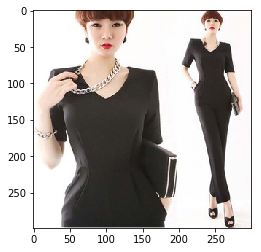

[95, 17, 66, 214, 164, 137, 20, 204, 184]


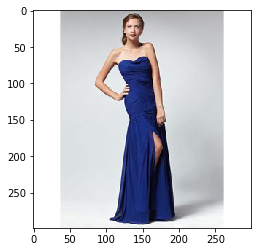

[122, 19, 66, 186, 180, 44, 154, 20]


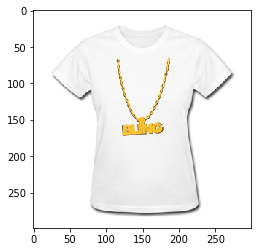

[190, 222, 66, 153, 164, 226, 53, 184]


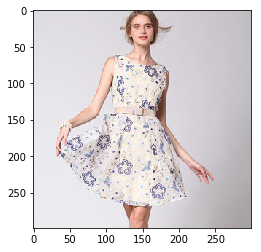

[62, 66, 153, 171, 111, 137, 70, 204, 184]


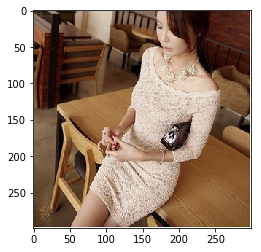

[62, 66, 153, 105, 14, 17, 98, 20]


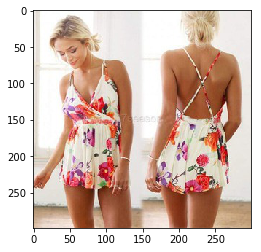

[12, 66, 214, 171, 111, 137, 70, 175, 54, 138]


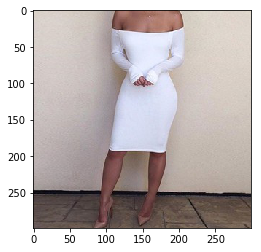

[62, 66, 116, 222, 105, 14, 176, 137, 53, 20]


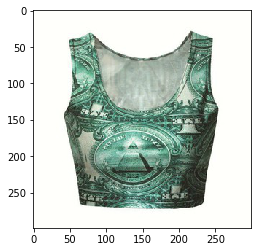

[56, 66, 171, 111, 210, 137, 184]


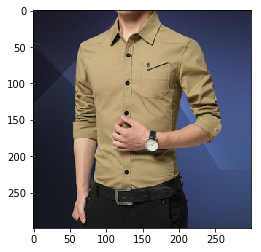

[61, 106, 49, 105, 14, 53]


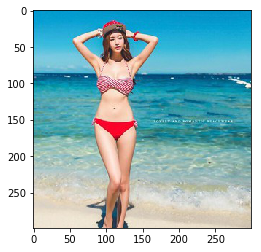

[15, 66, 148, 222, 186, 171, 176, 115, 181, 175]


In [38]:
data_path = '/home/shared/cs231n-fashion/data/validation_processed.tfrecords'  # address to save the hdf5 file

record_iterator = tf.python_io.tf_record_iterator(path=data_path)

counter=0
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    img_byte = (example.features.feature['image'].bytes_list
                                  .value[0])
    
    labels_string = (example.features.feature['labels']
                                .int64_list
                                .value)
    
    img_1d = np.fromstring(img_byte, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((299, 299, -1))
    plt.imshow(reconstructed_img)
    plt.show()
    print (labels_string)
    counter+=1
    
    if counter>10:
        break

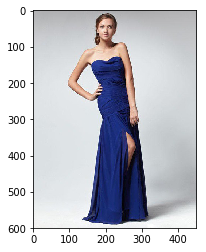

In [17]:
plt.imshow(Image.open("/home/fashion/data/validation_images/3.jpg"))

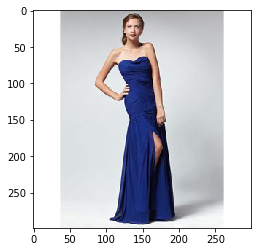

In [18]:
plt.imshow(Image.open("/home/fashion/data/validation_processed/3.jpg"))

In [112]:
tf.reset_default_graph()

In [113]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_SIZE = 299

tfrecords_filename = '/home/shared/cs231n-fashion/data/validation_processed.tfrecords'

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
      serialized_example,
      features={
        'image': tf.FixedLenFeature([], tf.string),
        'labels': tf.VarLenFeature(tf.int64),
        })
    
    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    label_sparse = tf.sparse_tensor_to_dense(features['labels'])
    label_dense = tf.reshape(label_sparse, (-1, 1))
    label = tf.scatter_nd(label_dense-1, tf.ones(tf.shape(label_dense)[0]), [228])
#     images, labels = tf.train.shuffle_batch([image, label],
#                                              batch_size=2,
#                                              capacity=2,
#                                              num_threads=2,
#                                              min_after_dequeue=1)
#     images, labels = tf.train.batch([image, label],
#                                     batch_size=1,
#                                     capacity=1,
#                                     num_threads=1,)
    return image, label, label_dense
#     return images, labels, label_dense

In [114]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation, label_sparse = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
with tf.Session()  as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(1):
    
        img, anno, label = sess.run([image, annotation, label_sparse])
        print(img.shape)
        print(anno, label)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

#         io.imshow(img[0, :, :, :])
#         io.show()

#         io.imshow(img[1, :, :, :])
#         io.show()

    coord.request_stop()
    coord.join(threads)

(299, 299, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [[ 62]
 [ 17]
 [ 66]
 [214]
 [105]
 [137]
 [ 85]]
current batch


In [117]:
data=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]


In [121]:
dan=np.array(data)
for i in range(len(dan)):
    if dan[i]==1:
        print(i+1)

17
62
66
85
105
137
214


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 

/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


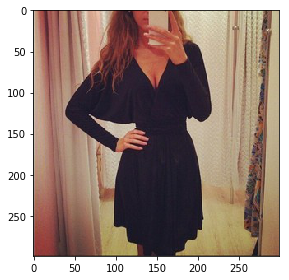

(32, 299, 299, 3) (32, 228)


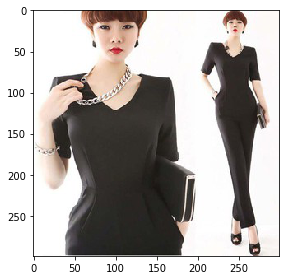

In [126]:
from input_fn import tf_record_input_fn

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
tfrecords_filename='/home/shared/cs231n-fashion/data/validation_processed.tfrecords'

data, label=tf_record_input_fn(tfrecords_filename, repeat=False, shuffle=False)

with tf.Session()  as sess:
    sess.run(init_op)
    img, labels = sess.run([data, label])
    print(labels[0])
    print(labels[1])
    io.imshow(img[0, :, :, :])
    io.show()
    io.imshow(img[1, :, :, :])
    print(img.shape, labels.shape)

In [127]:
b=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]

for i in range(len(b)):
    if b[i]==1:
        print(i+1)

17
62
66
85
105
137
214


In [3]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# tf.reset_default_graph()
def train_with_keras():
    # create the base pre-trained model
    base_model = Xception(weights='imagenet', include_top=False, classes=228)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    probs = Dense(228, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=probs)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    for i, layer in enumerate(base_model.layers):
       print(i, layer.name)

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    from keras.optimizers import SGD
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

train_with_keras()

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization_5
15 add_13
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_6
25 add_14
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_7
35 add_15
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_16
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [4]:
train_with_keras()

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_9
13 block2_pool
14 batch_normalization_9
15 add_25
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_10
23 block3_pool
24 batch_normalization_10
25 add_26
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_11
33 block4_pool
34 batch_normalization_11
35 add_27
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_28
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block